In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [32]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

print(device.type)

# ---

torch.manual_seed(42)
np.random.seed(42)

cuda


In [33]:
t_steps = 200
num_demos = 100
num_val = 20
dx, dy = 1, 1
x = torch.linspace(0, 1, t_steps).repeat(int(num_demos/2), 1)

noise = torch.clamp(torch.randn(x.shape)*1e-4**0.5, min=0)
y0 = torch.unsqueeze(torch.sin(x*torch.pi) + noise, 2)

y1 = 1-y0

x = torch.unsqueeze(x.repeat(2,1), 2)
y = torch.cat((y0, y1), 0)
print("X:", x.shape, "Y:", y.shape)

path = "."

#######################################

vx = torch.linspace(0, 1, t_steps).repeat(int(num_val/2), 1)
vnoise = torch.clamp(torch.randn(vx.shape)*1e-4**0.5, min=0)
vy0 = torch.unsqueeze(torch.sin(vx*torch.pi) + vnoise, 2)
vy1 = 1-vy0

vx = torch.unsqueeze(vx.repeat(2,1), 2)
vy = torch.cat((vy0, vy1), 0)

X: torch.Size([100, 200, 1]) Y: torch.Size([100, 200, 1])


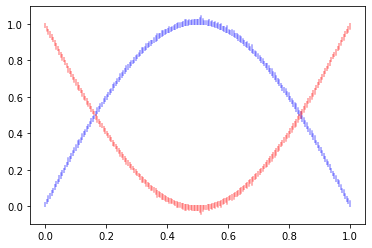

In [34]:
plt.plot(x[:50, :, 0], y[:50, :, 0], 'b', alpha=0.3)
plt.plot(x[51:, :, 0], y[51:, :, 0], 'r', alpha=0.3)
plt.show()

In [35]:
n_max = 6

def sample_training_demonstration():
    rand_traj_ind = np.random.randint(0, num_demos)
    n = np.random.randint(1, n_max+1)

    rand_traj = y[rand_traj_ind, :, :]

    observation_indices = np.random.choice(np.arange(t_steps), n+1, replace=False) # n+1: +1 is for sampling the target
    
    observations = torch.cat((rand_traj[observation_indices[:-1], :], 
                              x[rand_traj_ind, observation_indices[:-1], :]), 1)
    targetX = torch.unsqueeze(torch.Tensor(x[rand_traj_ind, observation_indices[-1], :]), 0)
    targetY = torch.unsqueeze(torch.Tensor(rand_traj[observation_indices[-1], :]), 0)
    
    if device.type == 'cuda':
        return observations.float().cuda(), targetX.float().cuda(), targetY.float().cuda()
    else:
        return observations.float(), targetX.float(), targetY.float()


def sample_training_demonstration_by_ind(i):
    rand_traj_ind = i
    n = np.random.randint(1, n_max+1)

    rand_traj = y[rand_traj_ind, :, :]
    observation_indices = np.random.choice(np.arange(t_steps), n+1, replace=False) # n+1: +1 is for sampling the target
    observations = torch.cat((rand_traj[observation_indices[:-1], :], 
                              x[rand_traj_ind, observation_indices[:-1], :]), 1)
    
    if device.type == 'cuda':
        return observations.float().cuda()
    else:
        return observations.float()


def get_validation_demonstration(ind):
    x = vx[ind, :, :]
    y = vy[ind, :, :]
    
    if device.type == 'cuda':
        return x.float().cuda(), y.float().cuda()
    else:
        return x, y

In [36]:
class BCNP(nn.Module):
    def __init__(self, in_shape):
        super(BCNP, self).__init__()
        
        dx, dy = in_shape[0], in_shape[1]
        
        self.dz = 128
        dzt = self.dz+dx
        
        self.encoder = nn.Sequential(
            nn.Linear(dx+dy, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, self.dz)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(dzt, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, dy*2)
        )

    def forward(self, observations, target):
        z_out = self.encoder(observations)
        z = torch.mean(z_out, dim=0)
        zs = z.repeat(target.shape[0], 1).to(device)  # repeating the same z for each target
        z_target = torch.cat((zs, target), 1)
        
        return self.decoder(z_target)

    def encode(self, observations):
        with torch.no_grad():
            z_out = self.encoder(observations)
            z = torch.mean(z_out, dim=0)
            return z


def log_prob_loss(ty, ty_pred):
    m, s = ty_pred.chunk(2, dim = -1)
    s = F.softplus(s)
    dist = D.Independent(D.Normal(loc=m, scale=s), 1)
    return -torch.mean(dist.log_prob(ty))


def validate():
    verr=torch.zeros(num_val)
    with torch.no_grad():
        for i in range(num_val):
            val_x, val_y = get_validation_demonstration(i)

            cond_step = 0
            observation = torch.Tensor([val_y[cond_step, :], val_x[cond_step, :]]).view(1, dx+dy).float().cuda()
            
            pred_traj = torch.zeros_like(val_y)
            pred_traj[cond_step, :] = val_y[cond_step, :]

            for t in range(1, t_steps):
                pred = model(observation, torch.unsqueeze(val_x[t], 0))
                pred_traj[t, :], _ = pred.chunk(2, dim = -1)  # pred[0]: mean, pred[1]: std

            verr[i] = torch.sum((val_y - pred_traj) ** 2)
    return torch.mean(verr)


def get_latent():
    latent = torch.zeros((num_demos, model.dz))

    for i in range(num_demos):
        obss = sample_training_demonstration_by_ind(i)
        latent[i, :] = model.encode(obss)
    
    np.save('latent.npy', latent.cpu().detach().numpy())

In [37]:
model = BCNP((1, 1))
model.to(device)

optimizer = torch.optim.Adam(lr=1e-4, params=model.parameters(), betas=(0.9, 0.999), amsgrad=True)

val_after_iter = 2500
iters = 5000000

losses = []
min_verr = 1e6

for i in range(iters):
    obss, tx, ty = sample_training_demonstration()
    
    optimizer.zero_grad()
    ty_preds = model(obss, tx)
    loss = log_prob_loss(ty, ty_preds)
    
    loss.backward()
    optimizer.step()
    
    if (i)%val_after_iter == 0:
        verr = validate()
        print(f"{i}: {verr}")
        losses.append(verr)

        if verr < min_verr:
            min_verr = verr
            torch.save(model.state_dict(), f'{path}/best_model_v1.pt')


0: 100.2658920288086
2500: 30.65598487854004
5000: 22.973257064819336
7500: 21.058055877685547
10000: 18.721914291381836
12500: 18.966182708740234
15000: 21.5734806060791
17500: 18.106555938720703
20000: 19.01730728149414
22500: 17.77058219909668
25000: 21.3878231048584
27500: 16.139511108398438
30000: 17.088733673095703
32500: 10.830767631530762
35000: 5.402866363525391
37500: 4.646346092224121
40000: 1.9040120840072632
42500: 0.8907017707824707
45000: 0.5147507190704346
47500: 0.8201325535774231
50000: 0.4759577214717865
52500: 1.024446725845337
55000: 0.10606016218662262
57500: 0.3758087456226349
60000: 0.34185177087783813
62500: 0.34401482343673706
65000: 0.24118411540985107
67500: 0.5239524245262146
70000: 0.17389722168445587
72500: 0.2472730576992035
75000: 0.1486395299434662
77500: 0.345618337392807
80000: 0.6173815727233887
82500: 0.08098356425762177
85000: 0.21113328635692596
87500: 0.11638003587722778
90000: 0.07661694288253784
92500: 0.3739415407180786
95000: 0.2791273891925

732500: 0.016599107533693314
735000: 0.01400649081915617
737500: 0.015847021713852882
740000: 0.024677006527781487
742500: 0.010331030003726482
745000: 0.01557003241032362
747500: 0.020084673538804054
750000: 0.03685189038515091
752500: 0.02564314566552639
755000: 0.022363940253853798
757500: 0.013095130212605
760000: 0.015891961753368378
762500: 0.018427755683660507
765000: 0.012737524695694447
767500: 0.011736404150724411
770000: 0.017974430695176125
772500: 0.011732293292880058
775000: 0.01729622483253479
777500: 0.016532164067029953
780000: 0.037857428193092346
782500: 0.0197974294424057
785000: 0.04989113658666611
787500: 0.014631533995270729
790000: 0.013604411855340004
792500: 0.017291028052568436
795000: 0.01382938027381897
797500: 0.011618747375905514
800000: 0.02115100994706154
802500: 0.01582697406411171
805000: 0.020700491964817047
807500: 0.02266976237297058
810000: 0.024624260142445564
812500: 0.011185750365257263
815000: 0.06629570573568344
817500: 0.015631722286343575
8

1432500: 0.013234679587185383
1435000: 0.012723092921078205
1437500: 0.020814970135688782
1440000: 0.01150249969214201
1442500: 0.012340067885816097
1445000: 0.02088714949786663
1447500: 0.00981408916413784
1450000: 0.010368986055254936
1452500: 0.02709038555622101
1455000: 0.021208683028817177
1457500: 0.015437260270118713
1460000: 0.020239796489477158
1462500: 0.01121381763368845
1465000: 0.013892263174057007
1467500: 0.013412443920969963
1470000: 0.01195727102458477
1472500: 0.014232100918889046
1475000: 0.018263552337884903
1477500: 0.020499270409345627
1480000: 0.014692519791424274
1482500: 0.010663683526217937
1485000: 0.013810954988002777
1487500: 0.013496102765202522
1490000: 0.011574318632483482
1492500: 0.016761887818574905
1495000: 0.014781286008656025
1497500: 0.018615426495671272
1500000: 0.020700160413980484
1502500: 0.04230345040559769
1505000: 0.012226000428199768
1507500: 0.017547274008393288
1510000: 0.012464487925171852
1512500: 0.013795988634228706
1515000: 0.016930

2122500: 0.009606709703803062
2125000: 0.01499966811388731
2127500: 0.011879955418407917
2130000: 0.010569104924798012
2132500: 0.012256037443876266
2135000: 0.009823458269238472
2137500: 0.010404742322862148
2140000: 0.03264893218874931
2142500: 0.01119411364197731
2145000: 0.018851492553949356
2147500: 0.009411496110260487
2150000: 0.011993478052318096
2152500: 0.009329549968242645
2155000: 0.008549012243747711
2157500: 0.017486685886979103
2160000: 0.011400946415960789
2162500: 0.01060795970261097
2165000: 0.011668139137327671
2167500: 0.021068256348371506
2170000: 0.02198154851794243
2172500: 0.020713800564408302
2175000: 0.009106600657105446
2177500: 0.008556059561669827
2180000: 0.011527862399816513
2182500: 0.009660421870648861
2185000: 0.014722573570907116
2187500: 0.010693276301026344
2190000: 0.010876225307583809
2192500: 0.012529199942946434
2195000: 0.00864030048251152
2197500: 0.009906674735248089
2200000: 0.010299419984221458
2202500: 0.009797018021345139
2205000: 0.00970

2812500: 0.00926316250115633
2815000: 0.01250079832971096
2817500: 0.011360345408320427
2820000: 0.010881206020712852
2822500: 0.009057651273906231
2825000: 0.010360319167375565
2827500: 0.009490050375461578
2830000: 0.011033990420401096
2832500: 0.00865896511822939
2835000: 0.013537807390093803
2837500: 0.011753156781196594
2840000: 0.008389795199036598
2842500: 0.011799974367022514
2845000: 0.008992058224976063
2847500: 0.009068865329027176
2850000: 0.011805933900177479
2852500: 0.01363052986562252
2855000: 0.008062510751187801
2857500: 0.008981043472886086
2860000: 0.029025796800851822
2862500: 0.016252506524324417
2865000: 0.009489387273788452
2867500: 0.013223649933934212
2870000: 0.013940973207354546
2872500: 0.010931205004453659
2875000: 0.017503341659903526
2877500: 0.012179650366306305
2880000: 0.009437723085284233
2882500: 0.01447897870093584
2885000: 0.009264661930501461
2887500: 0.015628261491656303
2890000: 0.009433357045054436
2892500: 0.00915814470499754
2895000: 0.01267

3502500: 0.010590435937047005
3505000: 0.009049765765666962
3507500: 0.014606961980462074
3510000: 0.018711311742663383
3512500: 0.016271233558654785
3515000: 0.010994466952979565
3517500: 0.015465440228581429
3520000: 0.00815376453101635
3522500: 0.012518187053501606
3525000: 0.009121294133365154
3527500: 0.008389364928007126
3530000: 0.013922725804150105
3532500: 0.00806256290525198
3535000: 0.009242450818419456
3537500: 0.012475634925067425
3540000: 0.00940154492855072
3542500: 0.008481101132929325
3545000: 0.008581580594182014
3547500: 0.010044177994132042
3550000: 0.00834222324192524
3552500: 0.008348566479980946
3555000: 0.010573845356702805
3557500: 0.010044245980679989
3560000: 0.010316165164113045
3562500: 0.028431737795472145
3565000: 0.010545828379690647
3567500: 0.009968447498977184
3570000: 0.008492592722177505
3572500: 0.00964954774826765
3575000: 0.00857584923505783
3577500: 0.010437289252877235
3580000: 0.009735788218677044
3582500: 0.011449640616774559
3585000: 0.00950

4192500: 0.012226752005517483
4195000: 0.007647261954843998
4197500: 0.009053166024386883
4200000: 0.010395096614956856
4202500: 0.010808459483087063
4205000: 0.008820254355669022
4207500: 0.009239290840923786
4210000: 0.010304486379027367
4212500: 0.0074846381321549416
4215000: 0.011112186126410961
4217500: 0.008157370612025261
4220000: 0.007809138856828213
4222500: 0.00761002441868186
4225000: 0.007971083745360374
4227500: 0.01159337442368269
4230000: 0.007920842617750168
4232500: 0.008516457863152027
4235000: 0.008716991171240807
4237500: 0.009505914524197578
4240000: 0.01004545297473669
4242500: 0.0077814264222979546
4245000: 0.0198292825371027
4247500: 0.00916832685470581
4250000: 0.008697139099240303
4252500: 0.007555811665952206
4255000: 0.011282269842922688
4257500: 0.008173804730176926
4260000: 0.01270601898431778
4262500: 0.00785308051854372
4265000: 0.008176435716450214
4267500: 0.007643646094948053
4270000: 0.009226739406585693
4272500: 0.010633428581058979
4275000: 0.00890

4880000: 0.008691733703017235
4882500: 0.01202528364956379
4885000: 0.007490129675716162
4887500: 0.00790055375546217
4890000: 0.007899085059762001
4892500: 0.0077514201402664185
4895000: 0.008009891025722027
4897500: 0.009538115933537483
4900000: 0.008097429759800434
4902500: 0.009640626609325409
4905000: 0.018008463084697723
4907500: 0.010702399536967278
4910000: 0.009252321906387806
4912500: 0.011123006232082844
4915000: 0.00763928284868598
4917500: 0.007666924502700567
4920000: 0.008056528866291046
4922500: 0.023762905970215797
4925000: 0.00762426620349288
4927500: 0.007839469239115715
4930000: 0.009100543335080147
4932500: 0.01690850406885147
4935000: 0.010895272716879845
4937500: 0.00866913516074419
4940000: 0.007880721241235733
4942500: 0.008839505724608898
4945000: 0.020153803750872612
4947500: 0.010303886607289314
4950000: 0.011678418144583702
4952500: 0.010645115748047829
4955000: 0.008600736036896706
4957500: 0.007877994328737259
4960000: 0.007467909716069698
4962500: 0.0087

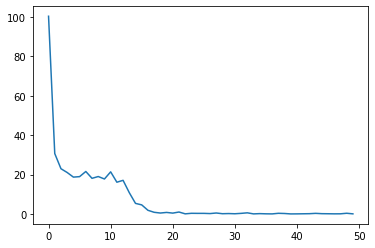

In [38]:
plt.plot(range(len(losses[:50])), losses[:50])

In [ ]:
get_latent()  # after training

In [41]:
from sklearn.cluster import KMeans


z = np.load('latent.npy')
res = KMeans(n_clusters=2, random_state=100).fit_predict(z)
print(res)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [42]:
sum(res)

50